In [6]:
# ============================================================================
# PROJECT FOLDER STRUCTURE
# ============================================================================
# game-behavior-analytics/
# ├── data_analysis_notebook/
# │   └── analysis(PL+SM).ipynb
# ├── data/
# │   └── final_dataset.csv

# Change to the correct directory
%cd game-behavior-analytics/data_analysis_notebook/ 

[Errno 2] No such file or directory: 'game-behavior-analytics/data_analysis_notebook/'
/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook


### Setup and Data Preparation

In [7]:

# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import os
import seaborn as sns

os.getcwd()

'/Users/suvadeep.mukherjee/Documents/game-behavior-intervention-study/game-behavior-analytics/data_analysis_notebook'

### DATA PREPARATION

In [8]:
df = pd.read_csv("../data/final_dataset.csv")

# Create categorical cheating behavior variable
def cheating_behavior(cheating_rate):
    return 0 if cheating_rate == 0 else (2 if cheating_rate == 1 else 1)  # Non-cheater=0, Partial cheater=1, Full cheater=2

df["cheating_behavior"] = df["cheating_rate_main_round"].apply(cheating_behavior)  # algorithm is in {game-behavior-analytics/cheating_analysis/cheating_analyzer.py}
df["experience"] = (df["task_satisfaction"] + df["task_engagement"]) / 2  # average of task satisfaction and task engagement
df["performance"] = df["performance_score_including_cheated_words"]  # performance includes legitimate + cheated words

# Drop rows with missing key outcome or predictor variables
df = df.dropna(subset=['cheating_behavior', 'performance', 'experience', 'concept', 'motivational_message_id'])


# Prepare data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

# We use this naming convention:
# Intervention (1=concept-based message shown; 0=control) → Concept (15 concepts from 4 theories) → Motivational Message (3 variations per concept)

concept_ids = df['concept'].astype('category')
if concept_ids.cat.categories[0] != 'control':
    concept_ids = concept_ids.cat.reorder_categories(['control'] + [c for c in concept_ids.cat.categories if c != 'control'])
concept_codes = concept_ids.cat.codes.values
concepts = [c for c in concept_ids.cat.categories if c != 'control']

message_ids = df['motivational_message_id'].astype('category')
message_codes = message_ids.cat.codes.values

# Extract outcome and predictor arrays
y_cheating_behavior = df['cheating_behavior'].values
y_performance = df['performance'].values
y_experience = df['experience'].values
is_partialCheater, is_fullCheater = (y_cheating_behavior == 1).astype(int), (y_cheating_behavior == 2).astype(int)

# Standard deviations
perf_std, exp_std = np.std(y_performance), np.std(y_experience)

# Control group baselines
control_data = df[df['concept'] == 'control']
control_cheating_dist = control_data['cheating_behavior'].value_counts(normalize=True).sort_index()
control_performance = control_data['performance'].mean()
control_experience = control_data['experience'].mean()




### Explorative Analysis: through Visualization of potential source of cheaters in intervention groups from control's performance distribution

Performance categories based on control group:
Low performance: ≤ 14.0
Medium performance: 14.0 - 24.0
High performance: > 24.0

Performance category distribution:
performance_category
Low Performer       496
Medium Performer    382
High Performer      354
Name: count, dtype: int64


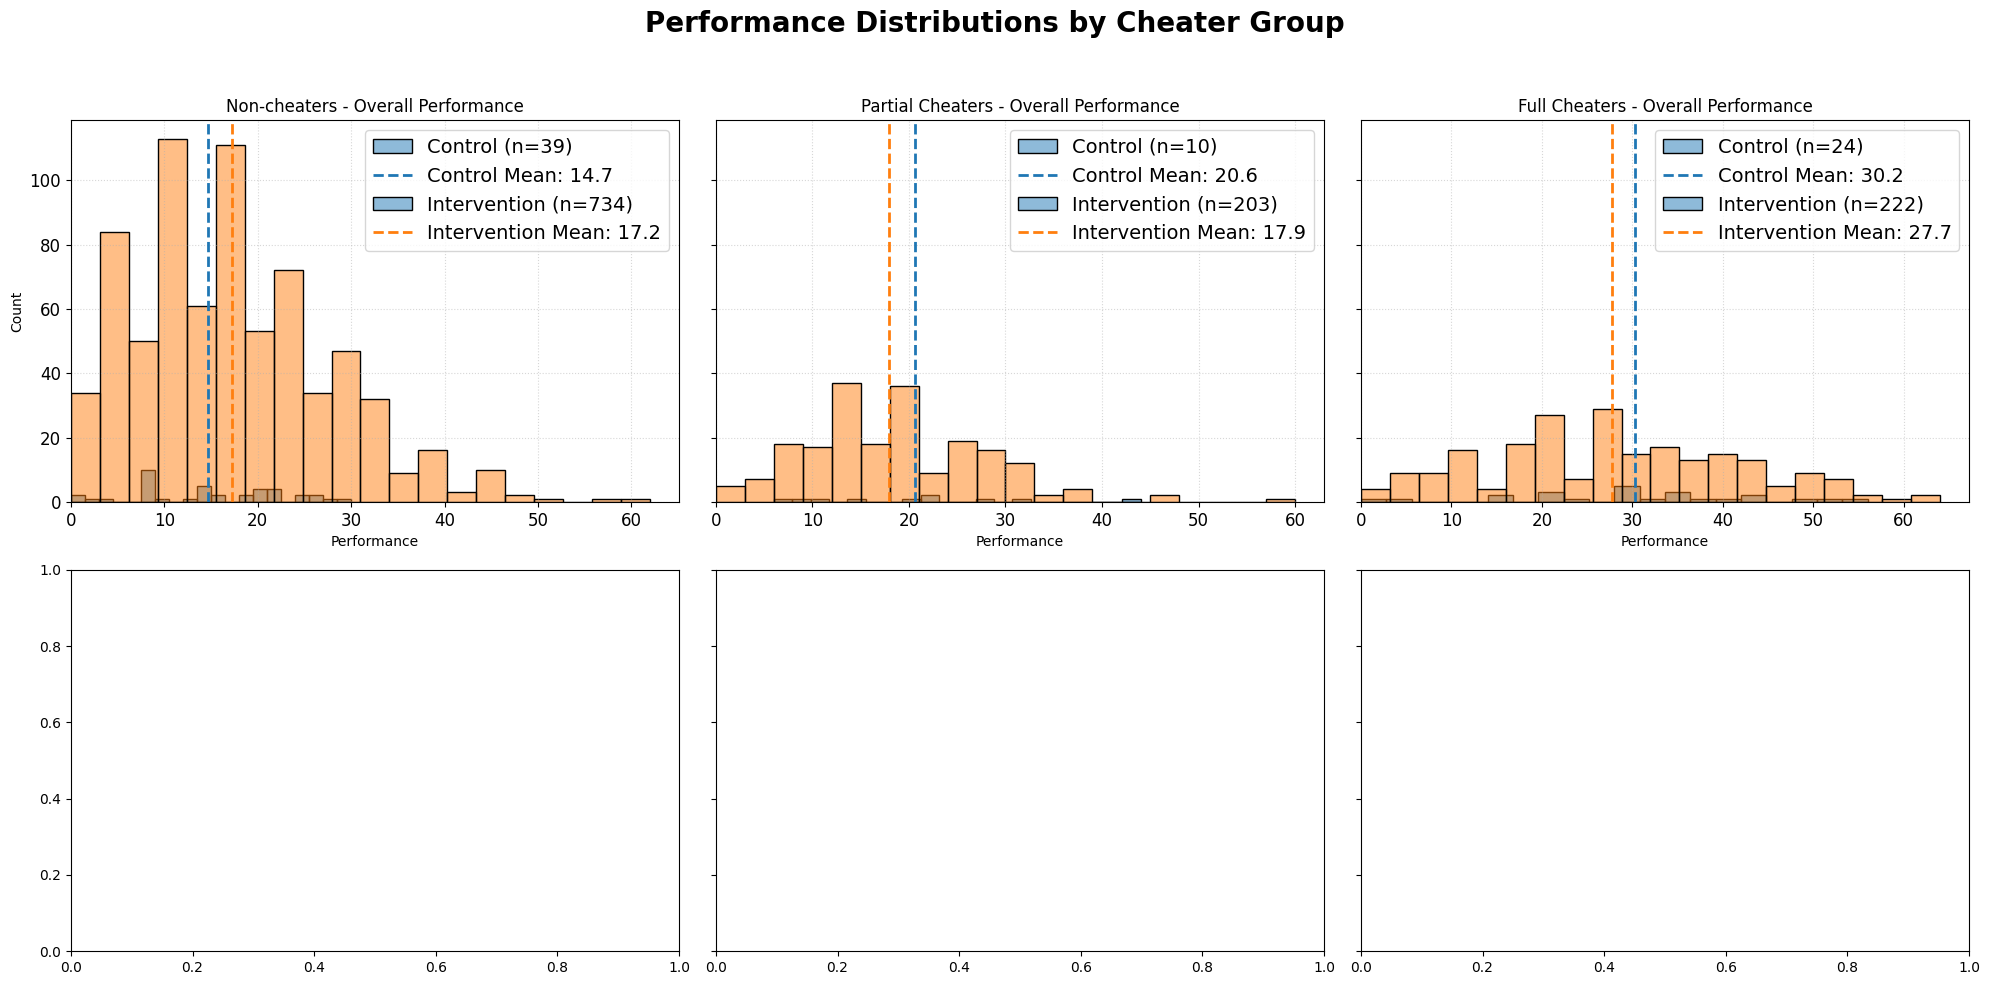

In [13]:
# =======================================================================================
# PERFORMANCE DISTRIBUTIONS FOR CONTROL vs INTERVENTION GROUPS
# =======================================================================================

# Define control performance percentiles for categorization
control_performance = df.loc[(df['concept']=='control') & (df['performance'] >= 0), 'performance'].dropna()
p33, p67 = np.percentile(control_performance, [33, 67])

print(f"Performance categories based on control group:")
print(f"Low performance: ≤ {p33:.1f}")
print(f"Medium performance: {p33:.1f} - {p67:.1f}")
print(f"High performance: > {p67:.1f}")

# Performance category assignment function
def get_performance_category(perf):
    if perf <= p33:
        return 'Low Performer'
    elif perf <= p67:
        return 'Medium Performer'
    else:
        return 'High Performer'

# Apply to dataframe
df['performance_category'] = df['performance'].apply(lambda x: get_performance_category(x) if x >= 0 else np.nan)
df['performance_category'] = pd.Categorical(df['performance_category'],
                                            categories=['Low Performer', 'Medium Performer', 'High Performer'],
                                            ordered=True)

# Update data splits
control_data = df[df['concept'] == 'control']
intervention_data = df[df['concept'] != 'control']

print(f"\nPerformance category distribution:")
print(df['performance_category'].value_counts())

# =======================================================================================
# CONSTANTS
# =======================================================================================

cheating_labels = {0: 'Non-cheaters', 1: 'Partial Cheaters', 2: 'Full Cheaters'}
category_colors = {'Low Performer': '#8dd3c7', 'Medium Performer': "#6f6f00", 'High Performer': '#bebada'}
control_color = '#1f77b4'
intervention_color = '#ff7f0e'

# Helper to get valid subset
def get_valid_subset(df, cheat_cat, perf_cat=None):
    subset = df[df['cheating_behavior'] == cheat_cat]
    if perf_cat:
        subset = subset[subset['performance_category'] == perf_cat]
    return subset['performance'].dropna()[lambda x: x >= 0]

# =======================================================================================
# PLOTTING FUNCTIONS
# =======================================================================================

def plot_cheater_group(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    control_subset = get_valid_subset(control_df, cheat_cat)
    intervention_subset = get_valid_subset(intervention_df, cheat_cat)
    
    handles, labels_ = [], []
    
    # Control histogram
    if len(control_subset) >= 3:
        hist = sns.histplot(control_subset, ax=ax, bins=20, color=control_color, alpha=0.5, edgecolor='black')
        mean_val = control_subset.mean()
        mean_line = ax.axvline(mean_val, color=control_color, linestyle='--', linewidth=2)
        handles += [hist.patches[0], mean_line]
        labels_ += [f"Control (n={len(control_subset)})", f"Control Mean: {mean_val:.1f}"]
    
    # Intervention histogram
    if len(intervention_subset) >= 3:
        hist = sns.histplot(intervention_subset, ax=ax, bins=20, color=intervention_color, alpha=0.5, edgecolor='black')
        mean_val = intervention_subset.mean()
        mean_line = ax.axvline(mean_val, color=intervention_color, linestyle='--', linewidth=2)
        handles += [hist.patches[0], mean_line]
        labels_ += [f"Intervention (n={len(intervention_subset)})", f"Intervention Mean: {mean_val:.1f}"]
    
    ax.set(title=f"{label} - Overall Performance", xlabel="Performance", ylabel="Count")
    ax.legend(handles=handles, labels=labels_, fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlim(left=0)
    ax.grid(True, linestyle=':', alpha=0.5)

def plot_cheater_group_by_perf_cat(ax, control_df, intervention_df, cheat_cat):
    label = cheating_labels[cheat_cat]
    
    for category in ['Low Performer', 'Medium Performer', 'High Performer']:
        c_subset = get_valid_subset(control_df, cheat_cat, category)
        i_subset = get_valid_subset(intervention_df, cheat_cat, category)
        
        if len(c_subset) >= 3:
            sns.kdeplot(c_subset, ax=ax, fill=True, alpha=0.2, color=category_colors[category],
                        label=f"{category} - Control (n={len(c_subset)})")
        
        if len(i_subset) >= 3:
            sns.kdeplot(i_subset, ax=ax, fill=False, linestyle='--', color=category_colors[category],
                        label=f"{category} - Intervention (n={len(i_subset)})")
    
    ax.set(title=f"{label} - Performance Categories", xlabel="Performance")
    ax.set_xlim(left=0)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# =======================================================================================
# PLOTTING 2x3 GRID: top row = overall; bottom row = performance categories
# =======================================================================================

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey='row')
fig.suptitle("Performance Distributions by Cheater Group",
             fontsize=20, fontweight='bold')

for i, cheat_cat in enumerate([0, 1, 2]):
    plot_cheater_group(axes[0, i], control_data, intervention_data, cheat_cat)
    # plot_cheater_group_by_perf_cat(axes[1, i], control_data, intervention_data, cheat_cat)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Skipped cell
<!-- #### Interpretation of the results above:

1. High performers can have **biggest impacts by interventions**
    - In the control, ~70% of high performers were full cheaters. Under intervention, this dropped dramatically to ~40% (↓30%).
    - The non-cheater proportion among high performers nearly tripled (~18% → ~47%). That ~30% could have moved from full cheaters to non-cheaters.
    - Interpretation: 
        - The interventions substantially could reduce cheating among high performers. It suggests that high performers might have the skills to achieve high scores without cheating but chose to cheat in control.
        - Under interventions (e.g. motivational messaging), they may choose honesty over maximizing scores without sacrificing experience (ΔExperience ≈ 0).

2. Medium performers can show **smaller cheating reductions**, but can show interesting patterns:
    - Full cheaters among medium performers reduced slightly (~23% → ~15%), a -8% change.
    - Partial cheaters increased (~14% → 20%, +6%).
    - Interpretation: 
        - Some full cheaters may have downgraded to partial cheating, and a small portion could become fully honest (non-cheaters ↑~2%).
        - Experience ratings for full cheaters in this group increased by +0.55, suggesting that interventions might have been helping them to be better engaged and satisfied.

3. Low performers were already **mostly honest**
    - Both in control and intervention, ~75% were non-cheaters. Very little change in cheating behavior:
        - Full cheaters reduced by only ~2%.
        - Partial cheaters increased by ~4% (from non-cheaters or full cheaters).
    - Experience: Low performer partial cheaters experienced a 1-point drop in experience under intervention.
        - This might imply: Messaging or intervention-induced guilt or inadequacy feelings among low performers who still cheated partially.


#### Key Takeaways:
##### Our interventions may not make weaker players cheat more if they are already mostly honest. The most notable effect we could see among high performers, where cheating can drastically be reduced under interventions without harming their experience. This suggests that behavioral interventions can transform those with the greatest capacity to cheat without diminishing their task engagement or satisfaction. -->

### Model 1: Cheating Behavior (Multinomial Logistic)

#### What this model does:
- Predicts probability of being non-cheater (reference), partial cheater, or full cheater
- Compares control group vs individual concepts using multinomial logistic regression

#### What we are looking for:
- Do interventions reduce cheating compared to control?
- Which concepts are most effective at reducing different types of cheating?
- Separate effects for partial vs full cheating behavior


In [16]:
control_data['cheating_behavior'].value_counts().sort_index()

cheating_behavior
0    39
1    10
2    24
Name: count, dtype: int64

In [18]:
# Model 1 data preparation - Cheating Behavior

# Calculate control group uncertainty based on actual sample sizes
control_counts = control_data['cheating_behavior'].value_counts().sort_index()
print("Control group counts:", control_counts.values)

# Calculate empirical log-odds and their standard errors
n_total = control_counts.sum()
n_non = control_counts[0]
n_partial = control_counts[1] 
n_full = control_counts[2]

# Logits for partialcheaters vs noncheaters, fullcheaters vs noncheaters
control_partialcheaters_logit = np.log(n_partial / n_non) if n_non > 0 else -2
control_fullcheaters_logit = np.log(n_full / n_non) if n_non > 0 else -1

# Standard errors for log-odds using delta method
# SE(log(p1/p0)) ≈ sqrt(1/n1 + 1/n0) where n1, n0 are counts
se_partialcheaters = np.sqrt(1/n_partial + 1/n_non) if n_partial > 0 and n_non > 0 else 1.0
se_fullcheaters = np.sqrt(1/n_full + 1/n_non) if n_full > 0 and n_non > 0 else 1.0

print(f"Control partial vs non log-odds: {control_partialcheaters_logit:.3f} ± {se_partialcheaters:.3f}")
print(f"Control full vs non log-odds: {control_fullcheaters_logit:.3f} ± {se_fullcheaters:.3f}")

Control group counts: [39 10 24]
Control partial vs non log-odds: -1.361 ± 0.354
Control full vs non log-odds: -0.486 ± 0.259



MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)
Fitting multinomial cheating behavior model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partialcheaters_intercept, beta_fullcheaters_intercept, concept_effects_partialcheaters, concept_effects_fullcheaters, message_effects_partialcheaters, message_effects_fullcheaters]


Output()

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 20 seconds.
Sampling: [cheating_obs]


Output()

Model fitted successfully!
Performing posterior predictive checks...


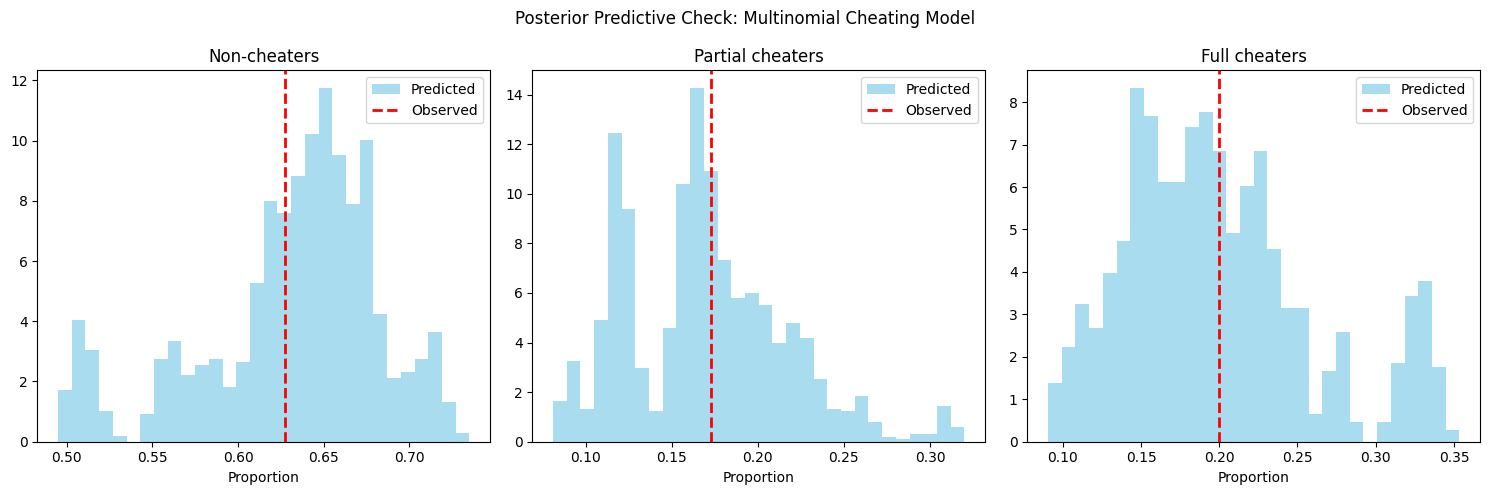

In [23]:
# ============================================================================
# MODEL 1: CHEATING BEHAVIOR (Multinomial Logistic)
#
# Multinomial logistic regression with non-cheaters as reference category:
#
# log_odds(partialcheaters vs noncheaters) = β₀_partialcheaters + Σ(β_i_partialcheaters × ConceptDummy_i) + message_effects_partialcheaters
# log_odds(fullcheaters vs noncheaters) = β₀_fullcheaters + Σ(β_i_fullcheaters × ConceptDummy_i) + message_effects_fullcheaters
#
# Where:
# - β₀: Control group baseline log-odds for each cheating type vs non-cheating
# - β_i: Effect of concept i on each cheating type (vs control)
# - message_effects: Random effects for motivational message variations
# ============================================================================

print("\n" + "="*80)
print("MODEL 1: CHEATING BEHAVIOR (MULTINOMIAL LOGISTIC)")
print("="*80)

with pm.Model() as cheating_model:
    
    # Control group baseline using empirical uncertainty
    beta_partialcheaters_intercept = pm.Normal('beta_partialcheaters_intercept', mu=control_partialcheaters_logit, sigma=se_partialcheaters)
    beta_fullcheaters_intercept = pm.Normal('beta_fullcheaters_intercept', mu=control_fullcheaters_logit, sigma=se_fullcheaters)
    
    # Concept effects on partialcheaters and fullcheaters cheating (vs non-cheating)
    concept_effects_partialcheaters = pm.Normal('concept_effects_partialcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    concept_effects_fullcheaters = pm.Normal('concept_effects_fullcheaters', mu=-1.0, sigma=1.0, shape=len(concepts))
    
    # Message effects
    message_effects_partialcheaters = pm.Normal('message_effects_partialcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    message_effects_fullcheaters = pm.Normal('message_effects_fullcheaters', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
    
    # Linear predictors (single expression)
    eta_partialcheaters = (beta_partialcheaters_intercept + message_effects_partialcheaters[message_codes] + 
                           pm.math.switch(concept_codes > 0, 
                            concept_effects_partialcheaters[concept_codes - 1], 0))
    
    eta_fullcheaters = (beta_fullcheaters_intercept + message_effects_fullcheaters[message_codes] +
                       pm.math.switch(concept_codes > 0, 
                        concept_effects_fullcheaters[concept_codes - 1], 0))
    
    # Multinomial logistic probabilities
    # Reference category is non-cheating (category 0), hence reference logit = 0
    logits = pm.math.stack([pm.math.zeros(eta_partialcheaters.shape), eta_partialcheaters, eta_fullcheaters], axis=1) 
    probs = pm.math.softmax(logits, axis=1)
    
    # Likelihood
    pm.Categorical('cheating_obs', p=probs, observed=y_cheating_behavior)

print("Fitting multinomial cheating behavior model...")
with cheating_model:
    trace_cheating = pm.sample(1000, tune=500, chains=4, cores=4, target_accept=0.9, random_seed=42)

print("Model fitted successfully!")

# Model checking
print("Performing posterior predictive checks...")
with cheating_model:
    ppc_cheating = pm.sample_posterior_predictive(trace_cheating, random_seed=42)


# Plot posterior predictive checks
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, category in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    observed_prop = (y_cheating_behavior == i).mean()
    predicted_props = (ppc_cheating.posterior_predictive['cheating_obs'] == i).mean(dim=['chain', 'draw'])
    
    axes[i].hist(predicted_props, bins=30, alpha=0.7, density=True, label='Predicted', color='skyblue')
    axes[i].axvline(observed_prop, color='red', linestyle='--', linewidth=2, label='Observed')
    axes[i].set_title(f'{category}')
    axes[i].set_xlabel('Proportion')
    axes[i].legend()

plt.suptitle('Posterior Predictive Check: Multinomial Cheating Model')
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 1
# ============================================================================
# graph = pm.model_to_graphviz(cheating_model)
# graph.render('cheating_model_graph', format='png')
display(pm.model_to_graphviz(cheating_model))
display(az.plot_ppc(ppc_cheating, num_pp_samples=100))

### Model 2: CONDITIONAL MODEL SELECTION FOR PERFORMANCE AND EXPERIENCE
#### What this model does:
- Predicts performance scores and experience ratings while accounting for cheating behavior differences
- Uses empirically-derived control group baselines calculated from actual control data by cheating category:
    - Performance: Calculated as control_means_perf = [mean for each cheating category] from observed data
    - Experience: Calculated as control_means_exp = [mean for each cheating category] from observed data
- Includes concept x cheating interactions to capture how interventions work differently for each cheating group
- Conditional modeling approach:
    - IF performance-experience correlation exists (≥3 groups with |r|>0.1): Uses multivariate model with correlation ρ
    - ELSE: Models performance and experience separately (independent models)

#### What we are looking for:
- Do interventions affect performance/experience differently for non-cheaters vs cheaters?
- Are there trade-offs? (e.g., concepts that reduce cheating but harm performance)
- Which concepts optimize all outcomes? (reduce cheating + maintain/improve performance + enhance experience)
- How strong is the performance-experience relationship? (correlation ρ)
- Concept-specific interaction effects: Do some concepts work better for certain cheating groups?


In [ ]:
# ============================================================================
# MODEL 2: CONDITIONAL MODEL SELECTION FOR PERFORMANCE AND EXPERIENCE
#
# IF correlation exists (≥3 groups with |r|>0.1):
#   MULTIVARIATE MODEL:
#   Performance = β₀_perf[cheating_cat] + Σ(β_i_perf × ConceptDummy_i) 
#               + Σ(β_i_perf_cheat × ConceptDummy_i × CheatingCat)
#               + message_effects_perf + ε_perf
#   
#   Experience = β₀_exp[cheating_cat] + Σ(β_i_exp × ConceptDummy_i) 
#              + Σ(β_i_exp_cheat × ConceptDummy_i × CheatingCat)
#              + message_effects_exp + ε_exp
#   
#   With covariance: Cov(ε_perf, ε_exp) = ρ × σ_perf × σ_exp
#
# ELSE:
#   SEPARATE MODELS:
#   Same equations but modeled independently (ρ = 0)
#
# Where:
# - β₀[cheating_cat]: Control baselines by cheating category
# - β_i: Main concept effects vs control  
# - β_i_cheat: Concept × cheating category interactions
# - ρ: Performance-experience correlation (multivariate only)
# ============================================================================

print("\n" + "="*80)
print("MODEL 2: CONDITIONAL MODEL SELECTION WITH CONTROL GROUP INTERCEPTS")
print("="*80)

# Calculate actual control group means by cheating category
control_means_perf = []
control_means_exp = []

for cheat_cat in [0, 1, 2]:
    control_subset = control_data[control_data['cheating_behavior'] == cheat_cat]
    
    if len(control_subset) > 0:
        perf_mean = control_subset['performance'].mean()
        exp_mean = control_subset['experience'].mean()
    else:
        # Fallback if no observations
        perf_mean = control_performance  # Overall control mean
        exp_mean = control_experience
    
    control_means_perf.append(perf_mean)
    control_means_exp.append(exp_mean)

print("Control group means by cheating category:")
print(f"Performance: {control_means_perf}")
print(f"Experience: {control_means_exp}")

# Check correlations between performance and experience
corr_results = []
cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}

for group_name, group_df in [('Control', control_data), ('Intervention', intervention_data)]:
    for cheat_cat in [0, 1, 2]:
        subset = group_df[group_df['cheating_behavior'] == cheat_cat]
        if len(subset) >= 10:
            corr = subset[['performance', 'experience']].corr().iloc[0, 1]
            corr_results.append((group_name, cheat_cat, len(subset), corr))
            print(f"{group_name} {cheating_labels[cheat_cat]} (n={len(subset)}): r={corr:.3f}")

# Decision criterion
significant_corrs = sum(1 for _, _, n, corr in corr_results if abs(corr) > 0.1 and n >= 10)
use_multivariate = significant_corrs >= 3

print(f"\nDecision: {significant_corrs}/6 groups have |r|>0.1")
print(f"Using {'multivariate' if use_multivariate else 'separate'} model(s)")

if use_multivariate:
    # ========================================================================
    # MULTIVARIATE MODEL: Performance + Experience with Correlation
    # ========================================================================
    
    with pm.Model() as multivariate_model:
        
        # Control baselines by cheating category
        mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
        mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
        
        # Concept effects (overall)
        concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
        concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
        
        # Concept effects (concept × cheating category)
        concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
        concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
        
        # Message effects
        msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
        msg_perf = pm.Normal('msg_perf', mu=0, sigma=0.5, shape=len(message_ids.cat.categories))
        
        # Linear predictors
        mu_exp = (mu_exp_control[y_cheating_behavior] + msg_exp[message_codes] + 
          pm.math.switch(concept_codes > 0,
                        concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating_behavior], 0))

        mu_perf = (mu_perf_control[y_cheating_behavior] + msg_perf[message_codes] + 
           pm.math.switch(concept_codes > 0,
                         concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating_behavior], 0))
        
        # Covariance structure
        sigma_exp = pm.HalfNormal('sigma_exp', sigma=0.4)
        sigma_perf = pm.HalfNormal('sigma_perf', sigma=5.0)
        
        rho = pm.Uniform('rho', lower=-0.5, upper=0.5)
        
        cov = pm.math.stack([[sigma_exp**2, rho*sigma_exp*sigma_perf],
                            [rho*sigma_exp*sigma_perf, sigma_perf**2]])
        
        # Multivariate likelihood
        outcomes = pm.math.stack([y_experience, y_performance], axis=1)
        means = pm.math.stack([mu_exp, mu_perf], axis=1)
        pm.MvNormal('outcomes', mu=means, cov=cov, observed=outcomes)
    
    print("Fitting multivariate model...")
    with multivariate_model:
        trace_multivariate = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_multivariate = pm.sample_posterior_predictive(trace_multivariate, var_names=['outcomes'])
    
    # Extract effects
    exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
    perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    rho_samples = trace_multivariate.posterior['rho'].values.flatten()
    
    print(f"Experience-Performance correlation: {rho_samples.mean():.3f} [{np.percentile(rho_samples, 2.5):.3f}, {np.percentile(rho_samples, 97.5):.3f}]")

else:
    # ========================================================================
    # SEPARATE MODELS: Performance and Experience Independently
    # ========================================================================
    
    # Experience Model
    with pm.Model() as experience_model:
        # UPDATED TO USE ACTUAL CONTROL VALUES
        mu_exp_control = pm.Normal('mu_exp_control', mu=control_means_exp, sigma=0.3, shape=3)
        concept_exp_main = pm.Normal('concept_exp_main', mu=0, sigma=0.2, shape=len(concepts))
        concept_exp_interactions = pm.Normal('concept_exp_interactions', mu=0, sigma=0.15, shape=(len(concepts), 3))
        msg_exp = pm.Normal('msg_exp', mu=0, sigma=0.1, shape=len(message_ids.cat.categories))
        
        mu_exp = mu_exp_control[y_cheating_behavior] + msg_exp[message_codes]
        mu_exp += pm.math.switch(concept_codes > 0,
                                concept_exp_main[concept_codes - 1] + concept_exp_interactions[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.TruncatedNormal('experience_obs', mu=mu_exp, sigma=pm.HalfNormal('sigma_exp', sigma=0.4),
                          lower=1, upper=7, observed=y_experience)
    
    # Performance Model  
    with pm.Model() as performance_model:
        # UPDATED TO USE ACTUAL CONTROL VALUES
        mu_perf_control = pm.Normal('mu_perf_control', mu=control_means_perf, sigma=3.0, shape=3)
        concept_perf_main = pm.Normal('concept_perf_main', mu=0, sigma=2.0, shape=len(concepts))
        concept_perf_interactions = pm.Normal('concept_perf_interactions', mu=0, sigma=1.5, shape=(len(concepts), 3))
        msg_perf = pm.Normal('msg_perf', mu=0, sigma=1.0, shape=len(message_ids.cat.categories))
        
        mu_perf = mu_perf_control[y_cheating_behavior] + msg_perf[message_codes]
        mu_perf += pm.math.switch(concept_codes > 0,
                                 concept_perf_main[concept_codes - 1] + concept_perf_interactions[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.TruncatedNormal('performance_obs', mu=mu_perf, sigma=pm.HalfNormal('sigma_perf', sigma=5.0),
                          lower=0, upper=y_performance.max() + 20, observed=y_performance)
    
    print("Fitting separate models...")
    with experience_model:
        trace_experience = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_experience = pm.sample_posterior_predictive(trace_experience, var_names=['experience_obs'])
    with performance_model:
        trace_performance = pm.sample(1000, tune=500, chains=4, cores=1, target_accept=0.9, random_seed=42)
        ppc_performance = pm.sample_posterior_predictive(trace_performance, var_names=['performance_obs'])
    
    # Extract effects
    exp_main = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
    perf_main = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    print("Models fitted independently (no correlation estimated)")

print("Model 2 Complete")

# ============================================================================
# POSTERIOR PREDICTIVE CHECKS FOR MODEL 2
# ============================================================================

if use_multivariate:
    # For multivariate model
    print("\nPosterior predictive checks for multivariate model...")
    
    # Create comprehensive PPC plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}
    
    # Plot for each group (Control/Intervention) and cheating category
    plot_idx = 0
    for group_name in ['Control', 'Intervention']:
        for cheat_cat in [0, 1, 2]:
            row = plot_idx // 3
            col = plot_idx % 3
            ax = axes[row, col]
            
            if group_name == 'Control':
                mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheat_cat)
            else:
                mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheat_cat)
            
            if mask.sum() > 0:
                # Observed data
                obs_exp = y_experience[mask]
                obs_perf = y_performance[mask]
                
                # Predicted data - extract from multivariate outcomes
                pred_outcomes = ppc_multivariate.posterior_predictive['outcomes'].values  # Shape: (chains, draws, observations, 2)
                pred_exp = pred_outcomes[:, :, mask, 0].flatten()  # Experience is index 0
                pred_perf = pred_outcomes[:, :, mask, 1].flatten()  # Performance is index 1
                
                # Subsample predictions to avoid overplotting
                n_pred_samples = min(len(pred_exp), len(obs_exp) * 50)
                pred_exp_sub = np.random.choice(pred_exp, n_pred_samples, replace=False)
                pred_perf_sub = np.random.choice(pred_perf, n_pred_samples, replace=False)
                
                # Create 2D histograms/scatter plots
                ax.scatter(obs_perf, obs_exp, alpha=0.7, color='red', s=20, label=f'Observed (n={mask.sum()})', edgecolor='black', linewidth=0.5)
                ax.scatter(pred_perf_sub, pred_exp_sub, alpha=0.1, color='blue', s=5, label='Predicted', rasterized=True)
                
                ax.set_title(f'{group_name} - {cheating_labels[cheat_cat]}', fontweight='bold')
                ax.set_xlabel('Performance')
                ax.set_ylabel('Experience')
                ax.grid(True, alpha=0.3)
                ax.legend()
                
                # Set reasonable axis limits
                ax.set_xlim(0, max(obs_perf.max(), np.percentile(pred_perf_sub, 99)) * 1.1)
                ax.set_ylim(1, 7)
            
            plot_idx += 1
    
    plt.suptitle('Posterior Predictive Check: Multivariate Model (Performance vs Experience)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    # Marginal distributions for experience and performance separately
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for outcome_idx, (outcome_name, outcome_data, ylim) in enumerate([
        ('Experience', y_experience, (1, 7)),
        ('Performance', y_performance, (0, y_performance.max() * 1.1))
    ]):
        for group_idx, (group_name, mask_func) in enumerate([
            ('Control', lambda: df['concept'] == 'control'),
            ('Intervention', lambda: df['concept'] != 'control'),
            ('Overall', lambda: np.ones(len(df), dtype=bool))
        ]):
            ax = axes[outcome_idx, group_idx]
            mask = mask_func()
            
            if mask.sum() > 0:
                # Observed
                obs_data = outcome_data[mask]
                
                # Predicted
                pred_data = ppc_multivariate.posterior_predictive['outcomes'].values[:, :, mask, outcome_idx].flatten()
                
                # Plot histograms
                if outcome_name == 'Experience':
                    bins = np.arange(1, 8, 0.5)
                else:
                    bins = 30
                
                ax.hist(obs_data, bins=bins, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
                ax.hist(pred_data[:len(obs_data)*20], bins=bins, alpha=0.5, density=True, label='Predicted', color='blue')
                
                ax.set_title(f'{group_name} - {outcome_name} (n={mask.sum()})')
                ax.set_xlabel(outcome_name)
                ax.set_ylabel('Density')
                ax.set_ylim(0, None)
                if outcome_name == 'Experience':
                    ax.set_xlim(1, 7)
                ax.legend()
                ax.grid(True, alpha=0.3)
    
    plt.suptitle('Posterior Predictive Check: Marginal Distributions', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    # For separate models
    print("\nPosterior predictive checks for separate models...")
    
    # Experience model PPC
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    cheating_labels = {0: 'Non-cheaters', 1: 'Partial cheaters', 2: 'Full cheaters'}
    
    for i, (group, cheating_cat) in enumerate([(g, c) for g in ['Control', 'Intervention'] for c in [0, 1, 2]]):
        ax = axes[i//3, i%3]
        
        if group == 'Control':
            mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheating_cat)
        else:
            mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheating_cat)
        
        if mask.sum() > 0:
            obs_exp = y_experience[mask]
            pred_exp = ppc_experience.posterior_predictive['experience_obs'].values[:, :, mask].flatten()
            
            bins = np.arange(1, 8, 0.5)
            ax.hist(obs_exp, bins=bins, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
            ax.hist(pred_exp[:len(obs_exp)*20], bins=bins, alpha=0.5, density=True, label='Predicted', color='blue')
            
            ax.set_title(f'{group} - {cheating_labels[cheating_cat]} (n={mask.sum()})')
            ax.set_xlabel('Experience')
            ax.set_xlim(1, 7)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('PPC: Experience Model by Group & Cheating Category', fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Performance model PPC
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    for i, (group, cheating_cat) in enumerate([(g, c) for g in ['Control', 'Intervention'] for c in [0, 1, 2]]):
        ax = axes[i//3, i%3]
        
        if group == 'Control':
            mask = (df['concept'] == 'control') & (df['cheating_behavior'] == cheating_cat)
        else:
            mask = (df['concept'] != 'control') & (df['cheating_behavior'] == cheating_cat)
        
        if mask.sum() > 0:
            obs_perf = y_performance[mask]
            pred_perf = ppc_performance.posterior_predictive['performance_obs'].values[:, :, mask].flatten()
            
            ax.hist(obs_perf, bins=20, alpha=0.7, density=True, label='Observed', color='red', edgecolor='black')
            ax.hist(pred_perf[:len(obs_perf)*20], bins=30, alpha=0.5, density=True, label='Predicted', color='blue')
            
            ax.set_title(f'{group} - {cheating_labels[cheating_cat]} (n={mask.sum()})')
            ax.set_xlabel('Performance')
            ax.set_xlim(0, None)
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('PPC: Performance Model by Group & Cheating Category', fontweight='bold')
    plt.tight_layout()
    plt.show()




MODEL 2: CONDITIONAL MODEL SELECTION WITH CONTROL GROUP INTERCEPTS
Control group means by cheating category:
Performance: [np.float64(14.666666666666666), np.float64(20.6), np.float64(30.25)]
Experience: [np.float64(5.51897435897436), np.float64(5.6865000000000006), np.float64(5.546041666666667)]
Control Non-cheaters (n=39): r=0.339
Control Partial cheaters (n=10): r=-0.427
Control Full cheaters (n=24): r=0.203
Intervention Non-cheaters (n=734): r=0.115
Intervention Partial cheaters (n=203): r=0.006
Intervention Full cheaters (n=222): r=0.222

Decision: 5/6 groups have |r|>0.1
Using multivariate model(s)
Fitting multivariate model...


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_exp_control, mu_perf_control, concept_exp_main, concept_perf_main, concept_exp_interactions, concept_perf_interactions, msg_exp, msg_perf, sigma_exp, sigma_perf, rho]


Output()

In [ ]:
# ============================================================================
# GRAPHICAL REPRESENTATION AND ROBUST CHECKING OF MODEL 2
# ============================================================================
# graph = pm.model_to_graphviz(experience_model)
# graph.render('experience_model_graph', format='png')
if use_multivariate:
    display(pm.model_to_graphviz(multivariate_model))
    display(az.plot_ppc(ppc_multivariate, num_pp_samples=100))
else:
    display(pm.model_to_graphviz(performance_model))
    display(az.plot_ppc(ppc_performance, num_pp_samples=100))
    display(pm.model_to_graphviz(experience_model))
    display(az.plot_ppc(ppc_experience, num_pp_samples=100))

### Summary of Findings (Posterior) and Plotting

In [ ]:
# ============================================================================
# LISTING ALL EFFECT SIZES OF ALL CONCEPTS ON ALL OUTCOMES VARIED BY CHEATER GROUP
# ============================================================================

# Theory mapping and ordering
theory_map = {
    "autonomy": "Self-Determination", "competence": "Self-Determination", "relatedness": "Self-Determination",
    "self_concept": "Cognitive Dissonance", "cognitive_inconsistency": "Cognitive Dissonance", 
    "dissonance_arousal": "Cognitive Dissonance", "dissonance_reduction": "Cognitive Dissonance",
    "performance_accomplishments": "Self-Efficacy", "vicarious_experience": "Self-Efficacy", 
    "verbal_persuasion": "Self-Efficacy", "emotional_arousal": "Self-Efficacy",
    "descriptive_norms": "Social Norms", "injunctive_norms": "Social Norms", 
    "social_sanctions": "Social Norms", "reference_group_identification": "Social Norms"
}

theory_order = [
    "autonomy", "competence", "relatedness",
    "self_concept", "cognitive_inconsistency", "dissonance_arousal", "dissonance_reduction",
    "performance_accomplishments", "vicarious_experience", "verbal_persuasion", "emotional_arousal",
    "descriptive_norms", "injunctive_norms", "social_sanctions", "reference_group_identification"
]

# ============================================================================
# 1. CHEATING BEHAVIOR EFFECTS
# ============================================================================

# Extract posterior samples
partial_effects = trace_cheating.posterior['concept_effects_partialcheaters'].values.reshape(-1, len(concepts))
full_effects = trace_cheating.posterior['concept_effects_fullcheaters'].values.reshape(-1, len(concepts))

# Convert log-odds to Cohen's d
cheating_effects = {}
for i, concept in enumerate(concepts):
    partial_d = partial_effects[:, i] * np.sqrt(3) / np.pi
    full_d = full_effects[:, i] * np.sqrt(3) / np.pi
    combined_d = -(np.abs(partial_d) + np.abs(full_d)) / 2
    
    cheating_effects[concept] = {
        'partial_d': partial_d.mean(),
        'partial_hdi': az.hdi(partial_d, hdi_prob=0.95),
        'full_d': full_d.mean(),
        'full_hdi': az.hdi(full_d, hdi_prob=0.95),
        'combined_d': combined_d.mean(),
        'combined_hdi': az.hdi(combined_d, hdi_prob=0.95)
    }

# ============================================================================
# 2. PERFORMANCE EFFECTS
# ============================================================================

if use_multivariate:
    # Extract from multivariate model
    perf_main = trace_multivariate.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_multivariate.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    performance_effects = {}
    for i, concept in enumerate(concepts):
        non_cheater_samples = (perf_main[:, i] + perf_int[:, i, 0]) / perf_std
        partial_cheater_samples = (perf_main[:, i] + perf_int[:, i, 1]) / perf_std
        full_cheater_samples = (perf_main[:, i] + perf_int[:, i, 2]) / perf_std
        overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
        
        performance_effects[concept] = {
            'non_cheater_d': non_cheater_samples.mean(),
            'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
            'partial_cheater_d': partial_cheater_samples.mean(),
            'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
            'full_cheater_d': full_cheater_samples.mean(),
            'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
            'overall_d': overall_samples.mean(),
            'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
        }
else:
    # Extract from separate performance model (same as before)
    perf_main = trace_performance.posterior['concept_perf_main'].values.reshape(-1, len(concepts))
    perf_int = trace_performance.posterior['concept_perf_interactions'].values.reshape(-1, len(concepts), 3)
    
    performance_effects = {}
    for i, concept in enumerate(concepts):
        non_cheater_samples = (perf_main[:, i] + perf_int[:, i, 0]) / perf_std
        partial_cheater_samples = (perf_main[:, i] + perf_int[:, i, 1]) / perf_std
        full_cheater_samples = (perf_main[:, i] + perf_int[:, i, 2]) / perf_std
        overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
        
        performance_effects[concept] = {
            'non_cheater_d': non_cheater_samples.mean(),
            'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
            'partial_cheater_d': partial_cheater_samples.mean(),
            'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
            'full_cheater_d': full_cheater_samples.mean(),
            'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
            'overall_d': overall_samples.mean(),
            'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
        }


# ============================================================================
# 3. EXPERIENCE EFFECTS
# ============================================================================

if use_multivariate:
    # Extract from multivariate model
    exp_main = trace_multivariate.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_multivariate.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)
else:
    # Extract from separate experience model
    exp_main = trace_experience.posterior['concept_exp_main'].values.reshape(-1, len(concepts))
    exp_int = trace_experience.posterior['concept_exp_interactions'].values.reshape(-1, len(concepts), 3)

experience_effects = {}
for i, concept in enumerate(concepts):
    non_cheater_samples = (exp_main[:, i] + exp_int[:, i, 0]) / exp_std
    partial_cheater_samples = (exp_main[:, i] + exp_int[:, i, 1]) / exp_std
    full_cheater_samples = (exp_main[:, i] + exp_int[:, i, 2]) / exp_std
    overall_samples = (non_cheater_samples + partial_cheater_samples + full_cheater_samples) / 3
    
    experience_effects[concept] = {
        'non_cheater_d': non_cheater_samples.mean(),
        'non_cheater_hdi': az.hdi(non_cheater_samples, hdi_prob=0.95),
        'partial_cheater_d': partial_cheater_samples.mean(),
        'partial_cheater_hdi': az.hdi(partial_cheater_samples, hdi_prob=0.95),
        'full_cheater_d': full_cheater_samples.mean(),
        'full_cheater_hdi': az.hdi(full_cheater_samples, hdi_prob=0.95),
        'overall_d': overall_samples.mean(),
        'overall_hdi': az.hdi(overall_samples, hdi_prob=0.95)
    }

# ============================================================================
# 4. COMPREHENSIVE EFFECT SIZE TABLE
# ============================================================================

# Calculate overall intervention effects (average across all concepts)
def calculate_overall_effects():
    """Calculate overall intervention effects by averaging across concepts"""
    
    # Overall cheating effects (unchanged)
    overall_partial_d = np.mean([cheating_effects[concept]['partial_d'] for concept in concepts])
    overall_full_d = np.mean([cheating_effects[concept]['full_d'] for concept in concepts])
    overall_combined_d = np.mean([cheating_effects[concept]['combined_d'] for concept in concepts])
    
    all_partial_samples = np.array([partial_effects[:, i] * np.sqrt(3) / np.pi for i in range(len(concepts))]).mean(axis=0)
    all_full_samples = np.array([full_effects[:, i] * np.sqrt(3) / np.pi for i in range(len(concepts))]).mean(axis=0)
    all_combined_samples = -(np.abs(all_partial_samples) + np.abs(all_full_samples)) / 2
    
    overall_cheating = {
        'partial_d': overall_partial_d,
        'partial_hdi': az.hdi(all_partial_samples, hdi_prob=0.95),
        'full_d': overall_full_d,
        'full_hdi': az.hdi(all_full_samples, hdi_prob=0.95),
        'combined_d': overall_combined_d,
        'combined_hdi': az.hdi(all_combined_samples, hdi_prob=0.95)
    }
    
    # Overall performance effects (UPDATED)
    all_perf_non = np.array([(perf_main[:, i] + perf_int[:, i, 0]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_partial = np.array([(perf_main[:, i] + perf_int[:, i, 1]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_full = np.array([(perf_main[:, i] + perf_int[:, i, 2]) / perf_std for i in range(len(concepts))]).mean(axis=0)
    all_perf_overall = (all_perf_non + all_perf_partial + all_perf_full) / 3
    
    overall_performance = {
        'non_cheater_d': all_perf_non.mean(),
        'non_cheater_hdi': az.hdi(all_perf_non, hdi_prob=0.95),
        'partial_cheater_d': all_perf_partial.mean(),
        'partial_cheater_hdi': az.hdi(all_perf_partial, hdi_prob=0.95),
        'full_cheater_d': all_perf_full.mean(),
        'full_cheater_hdi': az.hdi(all_perf_full, hdi_prob=0.95),
        'overall_d': all_perf_overall.mean(),
        'overall_hdi': az.hdi(all_perf_overall, hdi_prob=0.95)
    }
    
    # Overall experience effects (UPDATED)
    all_exp_non = np.array([(exp_main[:, i] + exp_int[:, i, 0]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_partial = np.array([(exp_main[:, i] + exp_int[:, i, 1]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_full = np.array([(exp_main[:, i] + exp_int[:, i, 2]) / exp_std for i in range(len(concepts))]).mean(axis=0)
    all_exp_overall = (all_exp_non + all_exp_partial + all_exp_full) / 3
    
    overall_experience = {
        'non_cheater_d': all_exp_non.mean(),
        'non_cheater_hdi': az.hdi(all_exp_non, hdi_prob=0.95),
        'partial_cheater_d': all_exp_partial.mean(),
        'partial_cheater_hdi': az.hdi(all_exp_partial, hdi_prob=0.95),
        'full_cheater_d': all_exp_full.mean(),
        'full_cheater_hdi': az.hdi(all_exp_full, hdi_prob=0.95),
        'overall_d': all_exp_overall.mean(),
        'overall_hdi': az.hdi(all_exp_overall, hdi_prob=0.95)
    }
    
    return overall_cheating, overall_performance, overall_experience


# Calculate overall effects
overall_cheating, overall_performance, overall_experience = calculate_overall_effects()

# Order concepts by cheating reduction effectiveness
cheat_effect_sizes = {concept: abs(cheating_effects[concept]['combined_d']) for concept in concepts}
concepts_ordered = sorted(concepts, key=lambda x: cheat_effect_sizes[x], reverse=True)

def print_comprehensive_table():
    """Print comprehensive effect size table with overall intervention effects"""
    
    print("\n" + "="*200)
    print("STANDARDIZED EFFECT SIZES (Cohen's d) WITH ODDS REDUCTIONS AND 95% HDI")
    print("="*200)
    
    # CHEATING BEHAVIOR WITH ODDS REDUCTIONS
    print(f"\n{'CHEATING BEHAVIOR EFFECTS (LOG-ODDS vs NON-CHEATERS)':^240}")
    print("-"*240)
    print(f"{'Concept':35} {'Theory':20} {'Partial vs Non':20} {'Full vs Non':20} {'Combined Effect':20} {'Partial OR%':10} {'Full OR%':10} {'Combined OR%':12}")
    print("-"*240)
    
    # Conversion factor for Cohen's d to log-odds
    conversion_factor = np.sqrt(3) / np.pi
    
    # OVERALL INTERVENTION EFFECT (first row)
    partial_d = overall_cheating['partial_d']
    partial_hdi = overall_cheating['partial_hdi']
    full_d = overall_cheating['full_d']
    full_hdi = overall_cheating['full_hdi']
    combined_d = overall_cheating['combined_d']
    combined_hdi = overall_cheating['combined_hdi']
    
    # Calculate odds reductions for all three
    partial_log_odds = partial_d / conversion_factor
    partial_odds_ratio = np.exp(partial_log_odds)
    partial_reduction = (1 - partial_odds_ratio) * 100
    
    full_log_odds = full_d / conversion_factor
    full_odds_ratio = np.exp(full_log_odds)
    full_reduction = (1 - full_odds_ratio) * 100
    
    combined_log_odds = combined_d / conversion_factor
    combined_odds_ratio = np.exp(combined_log_odds)
    combined_reduction = (1 - combined_odds_ratio) * 100
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {combined_d:6.3f}[{combined_hdi[0]:6.3f},{combined_hdi[1]:6.3f}] {partial_reduction:8.1f}% {full_reduction:8.1f}% {combined_reduction:10.1f}%")
    print("-"*240)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        partial_d = cheating_effects[concept]['partial_d']
        partial_hdi = cheating_effects[concept]['partial_hdi']
        full_d = cheating_effects[concept]['full_d']
        full_hdi = cheating_effects[concept]['full_hdi']
        combined_d = cheating_effects[concept]['combined_d']
        combined_hdi = cheating_effects[concept]['combined_hdi']
        
        # Calculate odds reductions for all three
        partial_log_odds = partial_d / conversion_factor
        partial_odds_ratio = np.exp(partial_log_odds)
        partial_reduction = (1 - partial_odds_ratio) * 100
        
        full_log_odds = full_d / conversion_factor
        full_odds_ratio = np.exp(full_log_odds)
        full_reduction = (1 - full_odds_ratio) * 100
        
        combined_log_odds = combined_d / conversion_factor
        combined_odds_ratio = np.exp(combined_log_odds)
        combined_reduction = (1 - combined_odds_ratio) * 100
        
        print(f"{name:35} {theory:20} {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {combined_d:6.3f}[{combined_hdi[0]:6.3f},{combined_hdi[1]:6.3f}] {partial_reduction:8.1f}% {full_reduction:8.1f}% {combined_reduction:10.1f}%")
    
    # PERFORMANCE EFFECTS
    print(f"\n{'PERFORMANCE EFFECTS':^200}")
    print("-"*200)
    print(f"{'Concept':35} {'Theory':20} {'Non-Cheater':20} {'Partial Cheater':20} {'Full Cheater':20} {'Combined':20}")
    print("-"*200)
    
    # OVERALL INTERVENTION EFFECT (first row)
    non_d = overall_performance['non_cheater_d']
    non_hdi = overall_performance['non_cheater_hdi']
    partial_d = overall_performance['partial_cheater_d']
    partial_hdi = overall_performance['partial_cheater_hdi']
    full_d = overall_performance['full_cheater_d']
    full_hdi = overall_performance['full_cheater_hdi']
    overall_d = overall_performance['overall_d']
    overall_hdi = overall_performance['overall_hdi']
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    print("-"*200)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        non_d = performance_effects[concept]['non_cheater_d']
        non_hdi = performance_effects[concept]['non_cheater_hdi']
        partial_d = performance_effects[concept]['partial_cheater_d']
        partial_hdi = performance_effects[concept]['partial_cheater_hdi']
        full_d = performance_effects[concept]['full_cheater_d']
        full_hdi = performance_effects[concept]['full_cheater_hdi']
        overall_d = performance_effects[concept]['overall_d']
        overall_hdi = performance_effects[concept]['overall_hdi']
        
        print(f"{name:35} {theory:20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    
    # EXPERIENCE EFFECTS
    print(f"\n{'EXPERIENCE EFFECTS':^200}")
    print("-"*200)
    print(f"{'Concept':35} {'Theory':20} {'Non-Cheater':20} {'Partial Cheater':20} {'Full Cheater':20} {'Combined':20}")
    print("-"*200)
    
    # OVERALL INTERVENTION EFFECT (first row)
    non_d = overall_experience['non_cheater_d']
    non_hdi = overall_experience['non_cheater_hdi']
    partial_d = overall_experience['partial_cheater_d']
    partial_hdi = overall_experience['partial_cheater_hdi']
    full_d = overall_experience['full_cheater_d']
    full_hdi = overall_experience['full_cheater_hdi']
    overall_d = overall_experience['overall_d']
    overall_hdi = overall_experience['overall_hdi']
    
    print(f"{'OVERALL INTERVENTION EFFECT':35} {'':20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")
    print("-"*200)
    
    # Individual concepts
    for concept in concepts_ordered:
        name = concept.replace('_', ' ').title()
        theory = theory_map.get(concept, 'Unknown')
        
        non_d = experience_effects[concept]['non_cheater_d']
        non_hdi = experience_effects[concept]['non_cheater_hdi']
        partial_d = experience_effects[concept]['partial_cheater_d']
        partial_hdi = experience_effects[concept]['partial_cheater_hdi']
        full_d = experience_effects[concept]['full_cheater_d']
        full_hdi = experience_effects[concept]['full_cheater_hdi']
        overall_d = experience_effects[concept]['overall_d']
        overall_hdi = experience_effects[concept]['overall_hdi']
        
        print(f"{name:35} {theory:20} {non_d:6.3f}[{non_hdi[0]:6.3f},{non_hdi[1]:6.3f}] {partial_d:6.3f}[{partial_hdi[0]:6.3f},{partial_hdi[1]:6.3f}] {full_d:6.3f}[{full_hdi[0]:6.3f},{full_hdi[1]:6.3f}] {overall_d:6.3f}[{overall_hdi[0]:6.3f},{overall_hdi[1]:6.3f}]")



# Print the table
print_comprehensive_table()


# RQ1 SUMMARY
print("\n" + "="*80)
print("RQ1 ANSWER: CONCEPT-BASED INTERVENTIONS AND CHEATING REDUCTION")
print("="*80)
print(f"Overall intervention effect: {overall_cheating['combined_d']:.3f} [{overall_cheating['combined_hdi'][0]:.3f}, {overall_cheating['combined_hdi'][1]:.3f}]")
print(f"Interpretation: Strong evidence for cheating reduction (Cohen's d > 0.5)")
print(f"All 15 concepts showed negative effects (range: {min([cheating_effects[c]['combined_d'] for c in concepts]):.3f} to {max([cheating_effects[c]['combined_d'] for c in concepts]):.3f})")
print(f"Most effective: {concepts_ordered[0].replace('_', ' ').title()}")
print(f"Least effective: {concepts_ordered[-1].replace('_', ' ').title()}")

# RQ2 SUMMARY  
print("\n" + "="*80)
print("RQ2 ANSWER: PERFORMANCE AND EXPERIENCE EFFECTS BY CHEATING GROUP")
print("="*80)
print("PERFORMANCE EFFECTS:")
for i, group in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    effect = overall_performance[['non_cheater_d', 'partial_cheater_d', 'full_cheater_d'][i]]
    hdi = overall_performance[['non_cheater_hdi', 'partial_cheater_hdi', 'full_cheater_hdi'][i]]
    print(f"  {group}: {effect:.3f} [{hdi[0]:.3f}, {hdi[1]:.3f}]")

print("\nEXPERIENCE EFFECTS:")
for i, group in enumerate(['Non-cheaters', 'Partial cheaters', 'Full cheaters']):
    effect = overall_experience[['non_cheater_d', 'partial_cheater_d', 'full_cheater_d'][i]]
    hdi = overall_experience[['non_cheater_hdi', 'partial_cheater_hdi', 'full_cheater_hdi'][i]]
    print(f"  {group}: {effect:.3f} [{hdi[0]:.3f}, {hdi[1]:.3f}]")
    
    



In [ ]:
# ===============================================================================================================================
# RQ1: VISUALIZATION OF CHANGES IN CHEATING BEHAVIOR, PERFORMANCE and EXPERIENCE BY ALL CONCEPTS VARIED OVER DIFFERENT CHEATING GROUPS
# ===============================================================================================================================

# Reverse ordering for visualization (least effective at top, most effective at bottom)
concepts_ordered_viz = list(reversed(concepts_ordered))

# Define colors
cheating_colors = ['#FE70EB', '#FF1745']  # Magenta for partial, Red for full
perf_exp_colors = ['#1f77b4', '#ff7f0e']  # Blue for performance, orange for experience

# Theory colors (unchanged)
theory_colors = {
    "autonomy": "#8B4513", "competence": "#8B4513", "relatedness": "#8B4513",
    "self_concept": "#4B0082", "cognitive_inconsistency": "#4B0082",
    "dissonance_arousal": "#4B0082", "dissonance_reduction": "#4B0082",
    "performance_accomplishments": "#006400", "vicarious_experience": "#006400",
    "verbal_persuasion": "#006400", "emotional_arousal": "#006400",
    "descriptive_norms": "#B8860B", "injunctive_norms": "#B8860B",
    "social_sanctions": "#B8860B", "reference_group_identification": "#B8860B"
}

# Prepare data for visualization
def prepare_viz_data():
    """Extract effect sizes and HDIs for visualization"""
    
    # Cheating behavior effects - CORRECTED
    partial_d = [cheating_effects[concept]['partial_d'] for concept in concepts_ordered_viz]
    full_d = [cheating_effects[concept]['full_d'] for concept in concepts_ordered_viz]
    
    partial_hdi = [cheating_effects[concept]['partial_hdi'] for concept in concepts_ordered_viz]
    full_hdi = [cheating_effects[concept]['full_hdi'] for concept in concepts_ordered_viz]
    
    # Performance effects by group
    perf_non = [performance_effects[concept]['non_cheater_d'] for concept in concepts_ordered_viz]
    perf_partial = [performance_effects[concept]['partial_cheater_d'] for concept in concepts_ordered_viz]
    perf_full = [performance_effects[concept]['full_cheater_d'] for concept in concepts_ordered_viz]
    
    perf_non_hdi = [performance_effects[concept]['non_cheater_hdi'] for concept in concepts_ordered_viz]
    perf_partial_hdi = [performance_effects[concept]['partial_cheater_hdi'] for concept in concepts_ordered_viz]
    perf_full_hdi = [performance_effects[concept]['full_cheater_hdi'] for concept in concepts_ordered_viz]
    
    # Experience effects by group
    exp_non = [experience_effects[concept]['non_cheater_d'] for concept in concepts_ordered_viz]
    exp_partial = [experience_effects[concept]['partial_cheater_d'] for concept in concepts_ordered_viz]
    exp_full = [experience_effects[concept]['full_cheater_d'] for concept in concepts_ordered_viz]
    
    exp_non_hdi = [experience_effects[concept]['non_cheater_hdi'] for concept in concepts_ordered_viz]
    exp_partial_hdi = [experience_effects[concept]['partial_cheater_hdi'] for concept in concepts_ordered_viz]
    exp_full_hdi = [experience_effects[concept]['full_cheater_hdi'] for concept in concepts_ordered_viz]
    
    # Calculate error bars
    def calc_err(values, hdis):
        return [[v - h[0] for v, h in zip(values, hdis)], [h[1] - v for v, h in zip(values, hdis)]]
    
    return {
        'cheating': {
            'partial': partial_d, 
            'full': full_d,
            'partial_err': calc_err(partial_d, partial_hdi),
            'full_err': calc_err(full_d, full_hdi),
            'means': [np.mean(partial_d), np.mean(full_d)]
        },
        'performance': {
            'non': perf_non, 'partial': perf_partial, 'full': perf_full,
            'non_err': calc_err(perf_non, perf_non_hdi),
            'partial_err': calc_err(perf_partial, perf_partial_hdi),
            'full_err': calc_err(perf_full, perf_full_hdi),
            'means': [np.mean(perf_non), np.mean(perf_partial), np.mean(perf_full)]
        },
        'experience': {
            'non': exp_non, 'partial': exp_partial, 'full': exp_full,
            'non_err': calc_err(exp_non, exp_non_hdi),
            'partial_err': calc_err(exp_partial, exp_partial_hdi),
            'full_err': calc_err(exp_full, exp_full_hdi),
            'means': [np.mean(exp_non), np.mean(exp_partial), np.mean(exp_full)]
        }
    }

# Prepare data
data = prepare_viz_data()
y_pos = range(len(concepts_ordered_viz))
width = 0.25

# Create 1x4 grid visualization
fig, axes = plt.subplots(1, 4, figsize=(20, 10))

# Plot 1: Cheating behavior changes
ax1 = axes[0]
ax1.barh([y - width/2 for y in y_pos], data['cheating']['partial'], width, 
         xerr=data['cheating']['partial_err'], capsize=3, error_kw={'alpha': 0.3},
         color=cheating_colors[0], alpha=0.7)
ax1.barh([y + width/2 for y in y_pos], data['cheating']['full'], width,
         xerr=data['cheating']['full_err'], capsize=3, error_kw={'alpha': 0.3},
         color=cheating_colors[1], alpha=0.7)

ax1.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1.5)
for i, mean in enumerate(data['cheating']['means']):
    ax1.axvline(mean, color=cheating_colors[i], linestyle='--', alpha=0.8, linewidth=1)

# ax1.set_title('Impact of concepts on cheating behavior change for\npartial and full cheaters from non-cheaters: bars\nfurther left or right = stronger cheating reduction', fontweight='bold', fontsize=11)
ax1.set_title('Cheating reduction effects by concept:\npartial and full cheating vs non-cheating\n(negative values = less cheating)', fontweight='bold', fontsize=11)
ax1.set_xlabel('Standardized Effect Size with 95% HDI\nCompared to Control', fontweight='bold', fontsize=10)
ax1.set_ylabel('Intervention Concepts (colored by theory)', fontweight='bold', fontsize=10)
ax1.set_yticks(y_pos)
ax1.set_yticklabels([c.replace('_', ' ').title() for c in concepts_ordered_viz], fontsize=9)
ax1.grid(axis='x', alpha=0.3)
ax1.legend()

# Add theory color coding to y-labels
for i, concept in enumerate(concepts_ordered_viz):
    label_color = theory_colors.get(concept, 'black')
    ax1.get_yticklabels()[i].set_color(label_color)
    ax1.get_yticklabels()[i].set_fontweight('bold')

# Function for performance/experience plots
def plot_group_outcome(ax, outcome_type, group_name, group_label):
    group_data = data[outcome_type]
    
    perf_values = group_data[group_name]
    exp_values = data['experience'][group_name]
    
    ax.barh([y - width/2 for y in y_pos], perf_values, width,
           xerr=group_data[f'{group_name}_err'], capsize=3, error_kw={'alpha': 0.3},
           color=perf_exp_colors[0], alpha=0.7)
    ax.barh([y + width/2 for y in y_pos], exp_values, width,
           xerr=data['experience'][f'{group_name}_err'], capsize=3, error_kw={'alpha': 0.3},
            color=perf_exp_colors[1], alpha=0.7)
    
    ax.axvline(0, color='black', linestyle='-', alpha=0.8, linewidth=1.5)
    ax.axvline(data['performance']['means'][['non', 'partial', 'full'].index(group_name)], 
               color=perf_exp_colors[0], linestyle='--', alpha=0.8, linewidth=2)
    ax.axvline(data['experience']['means'][['non', 'partial', 'full'].index(group_name)], 
               color=perf_exp_colors[1], linestyle='--', alpha=0.8, linewidth=2)
    
    ax.set_title(f'{group_label}: Impact of concepts on\nperformance & experience change (Bars\nright = improvement; left = reduction)', fontweight='bold', fontsize=11)
    ax.set_xlabel('Standardized Effect Size with 95% HDI\nCompared to Control', fontweight='bold', fontsize=10)
    ax.set_yticks([])
    ax.grid(axis='x', alpha=0.3)
    ax.legend()

# Plots 2-4: Performance and Experience effects for each group
group_specs = [('non', 'Non-Cheaters'), ('partial', 'Partial Cheaters'), ('full', 'Full Cheaters')]
for i, (group_name, group_label) in enumerate(group_specs):
    plot_group_outcome(axes[i+1], 'performance', group_name, group_label)

# Create legends
theory_legend = [plt.Rectangle((0,0), 1, 1, color=color, label=theory) 
                for theory, color in [('Self-Determination', '#8B4513'), ('Cognitive Dissonance', '#4B0082'),
                                     ('Self-Efficacy', '#006400'), ('Social Norms', '#B8860B')]]

outcome_legend = [plt.Rectangle((0,0), 1, 1, color=color, alpha=0.7, label=label) 
                 for color, label in [(cheating_colors[0], 'Partial Cheater'), (cheating_colors[1], 'Full Cheater'),
                                     (perf_exp_colors[0], 'Performance'), (perf_exp_colors[1], 'Experience')]]

reference_legend = [plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='No Effect (d=0)'),
                   plt.Line2D([0], [0], color='gray', linestyle='--', linewidth=1.5, label='Group Mean')]

# Add legends
fig.legend(handles=theory_legend, loc='lower left', bbox_to_anchor=(0.02, 0.01), 
          title='Theory Labels', fontsize=9, title_fontsize=10)
fig.legend(handles=outcome_legend, loc='lower center', bbox_to_anchor=(0.5, 0.01), 
          title='Outcome Bars', fontsize=9, title_fontsize=10, ncol=2)
fig.legend(handles=reference_legend, loc='lower right', bbox_to_anchor=(0.98, 0.01), 
          title='Reference Lines', fontsize=9, title_fontsize=10)

plt.suptitle('Concept-Based interventions can reduce cheating behavior without compromising performance and experience?\nFirst plot shows cheating reduction in all cheating groups for each concept; remaining plots show performance/experience effects by each cheating group', 
             fontsize=14, fontweight='bold', y=0.95)
plt.figtext(0.5, 0.88, 'Effect sizes are shown as Cohen\'s d standardized estimates for cheating reduction (log-odds scale), performance scores, and experience ratings', 
           ha='center', fontsize=11, style='italic')
plt.tight_layout(rect=[0, 0.12, 1, 0.89])
plt.show()


### Mediation Analysis: Concept → Mediators → Performance/Experience for Cheating Groups

In [ ]:
# ============================================================================
# MODEL 3: MEDIATION ANALYSIS FOR RQ3
# Research Question: How do concepts influence outcomes through mediators?
# ============================================================================

# Prepare mediator variables (standardized)
mediators = {
    'ability': (df['word_creation_skill_level'] - df['word_creation_skill_level'].mean()) / df['word_creation_skill_level'].std(),
    'honesty': (df['moral_disengagement'] - df['moral_disengagement'].mean()) / df['moral_disengagement'].std(),
    'discomfort': (df['cognitive_discomfort'] - df['cognitive_discomfort'].mean()) / df['cognitive_discomfort'].std()
}

# MODEL 3A: Concepts → Mediators (PATH A) - GROUP-SPECIFIC
with pm.Model() as mediator_model:
    for med_name, med_values in mediators.items():
        # Group-specific baselines
        baseline = pm.Normal(f'{med_name}_baseline', mu=0, sigma=0.5, shape=3)
        
        # Group-specific concept effects: [concept, group]
        concept_effects = pm.Normal(f'{med_name}_concept_effects', mu=0, sigma=0.3, shape=(len(concepts), 3))
        
        # Message effects (same across groups)
        message_effects = pm.Normal(f'{med_name}_message_effects', mu=0, sigma=0.2, shape=len(message_ids.cat.categories))
        
        # Linear predictor with group-specific effects
        mu = baseline[y_cheating_behavior] + message_effects[message_codes]
        mu += pm.math.switch(concept_codes > 0, 
                            concept_effects[concept_codes - 1, y_cheating_behavior], 0)
        
        pm.Normal(f'{med_name}_obs', mu=mu, sigma=pm.HalfNormal(f'{med_name}_sigma', sigma=0.5), 
                 observed=med_values)

# MODEL 3B: Mediators + Concepts → Outcomes by Group (PATH B + C')
with pm.Model() as outcome_model:
    mediator_matrix = np.column_stack([mediators['ability'], mediators['honesty'], mediators['discomfort']])
    
    # Performance
    perf_baseline = pm.Normal('perf_baseline', mu=control_means_perf, sigma=2.0, shape=3)
    perf_mediator_effects = pm.Normal('perf_mediator_effects', mu=0, sigma=1.0, shape=(3, 3))  # [mediator, group]
    perf_concept_direct = pm.Normal('perf_concept_direct', mu=0, sigma=1.5, shape=(len(concepts), 3))  # [concept, group]
    
    mu_perf = perf_baseline[y_cheating_behavior]
    for med_idx in range(3):
        mu_perf += mediator_matrix[:, med_idx] * perf_mediator_effects[med_idx, y_cheating_behavior]
    mu_perf += pm.math.switch(concept_codes > 0, perf_concept_direct[concept_codes - 1, y_cheating_behavior], 0)
    
    # Experience
    exp_baseline = pm.Normal('exp_baseline', mu=control_means_exp, sigma=0.3, shape=3)
    exp_mediator_effects = pm.Normal('exp_mediator_effects', mu=0, sigma=0.3, shape=(3, 3))
    exp_concept_direct = pm.Normal('exp_concept_direct', mu=0, sigma=0.3, shape=(len(concepts), 3))
    
    mu_exp = exp_baseline[y_cheating_behavior]
    for med_idx in range(3):
        mu_exp += mediator_matrix[:, med_idx] * exp_mediator_effects[med_idx, y_cheating_behavior]
    mu_exp += pm.math.switch(concept_codes > 0, exp_concept_direct[concept_codes - 1, y_cheating_behavior], 0)
    
    # Likelihoods
    pm.Normal('performance_mediated', mu=mu_perf, sigma=pm.HalfNormal('perf_sigma_med', sigma=5.0), observed=y_performance)
    pm.Normal('experience_mediated', mu=mu_exp, sigma=pm.HalfNormal('exp_sigma_med', sigma=0.5), observed=y_experience)

# Fit models
print("Fitting mediation models...")
with mediator_model:
    trace_mediators = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

with outcome_model:
    trace_outcomes = pm.sample(1000, tune=500, chains=4, cores=4, random_seed=42)

print("Models fitted successfully!")



In [ ]:
# ============================================================================
# MEDIATION ANALYSIS HEATMAP VISUALIZATION
# Extract coefficients from fitted models and create 3x3 heatmap grid
# ============================================================================

# Extract PATH A coefficients (Concepts → Mediators by Cheating Group)
# From trace_mediators
path_a_effects = {}
mediator_names = ['ability', 'honesty', 'discomfort']
cheating_groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

for med_name in mediator_names:
    # Extract concept effects: shape (samples, concepts, groups)
    effects = trace_mediators.posterior[f'{med_name}_concept_effects'].values
    # Average across samples to get mean effects
    mean_effects = effects.mean(axis=(0,1))  # Shape: (concepts, groups)
    path_a_effects[med_name] = mean_effects

# Extract PATH B coefficients (Mediators → Outcomes by Cheating Group)
# From trace_outcomes
path_b_performance = trace_outcomes.posterior['perf_mediator_effects'].values.mean(axis=(0,1))  # Shape: (mediators, groups)
path_b_experience = trace_outcomes.posterior['exp_mediator_effects'].values.mean(axis=(0,1))   # Shape: (mediators, groups)

# Extract PATH C' coefficients (Direct Concept → Outcomes by Cheating Group)
# From trace_outcomes
path_c_performance = trace_outcomes.posterior['perf_concept_direct'].values.mean(axis=(0,1))  # Shape: (concepts, groups)
path_c_experience = trace_outcomes.posterior['exp_concept_direct'].values.mean(axis=(0,1))   # Shape: (concepts, groups)

# Concept ordering (from your previous analysis - ordered by cheating reduction effectiveness)
concepts_ordered_mediation = [
    'reference_group_identification', 'cognitive_inconsistency', 'competence', 
    'autonomy', 'verbal_persuasion', 'dissonance_arousal', 'relatedness',
    'self_concept', 'descriptive_norms', 'dissonance_reduction', 
    'vicarious_experience', 'injunctive_norms', 'social_sanctions',
    'emotional_arousal', 'performance_accomplishments'
]

# Create concept labels
concept_labels = [c.replace('_', ' ').title() for c in concepts_ordered_mediation]

def calculate_indirect_effects():
    """Calculate indirect effects with proper uncertainty quantification"""
    
    # Extract posterior samples
    ability_effects = trace_mediators.posterior['ability_concept_effects'].values  # (chains, draws, concepts, groups)
    honesty_effects = trace_mediators.posterior['honesty_concept_effects'].values
    discomfort_effects = trace_mediators.posterior['discomfort_concept_effects'].values
    
    perf_mediator_effects = trace_outcomes.posterior['perf_mediator_effects'].values  # (chains, draws, mediators, groups)
    exp_mediator_effects = trace_outcomes.posterior['exp_mediator_effects'].values
    
    # Reshape to (samples, concepts, groups) and (samples, mediators, groups)
    ability_samples = ability_effects.reshape(-1, len(concepts), 3)
    honesty_samples = honesty_effects.reshape(-1, len(concepts), 3)
    discomfort_samples = discomfort_effects.reshape(-1, len(concepts), 3)
    
    perf_med_samples = perf_mediator_effects.reshape(-1, 3, 3)
    exp_med_samples = exp_mediator_effects.reshape(-1, 3, 3)
    
    # Calculate indirect effects for heatmaps (mean effects only)
    indirect_perf = np.zeros((len(concepts), 3))  # concepts x groups
    indirect_exp = np.zeros((len(concepts), 3))
    
    for concept_idx in range(len(concepts)):
        for group_idx in range(3):
            # Total indirect effect = sum across all mediators
            total_perf = (ability_samples[:, concept_idx, group_idx] * perf_med_samples[:, 0, group_idx] +
                         honesty_samples[:, concept_idx, group_idx] * perf_med_samples[:, 1, group_idx] +
                         discomfort_samples[:, concept_idx, group_idx] * perf_med_samples[:, 2, group_idx])
            
            total_exp = (ability_samples[:, concept_idx, group_idx] * exp_med_samples[:, 0, group_idx] +
                        honesty_samples[:, concept_idx, group_idx] * exp_med_samples[:, 1, group_idx] +
                        discomfort_samples[:, concept_idx, group_idx] * exp_med_samples[:, 2, group_idx])
            
            indirect_perf[concept_idx, group_idx] = total_perf.mean()
            indirect_exp[concept_idx, group_idx] = total_exp.mean()
    
    # Calculate detailed effects for summary table
    detailed_results = {}
    for concept_idx, concept in enumerate(concepts):
        concept_name = concept.replace('_', ' ').title()
        detailed_results[concept_name] = {}
        
        for group_idx, group in enumerate(['Non-Cheater', 'Partial Cheater', 'Full Cheater']):
            # Individual pathway effects
            ability_to_perf = ability_samples[:, concept_idx, group_idx] * perf_med_samples[:, 0, group_idx]
            ability_to_exp = ability_samples[:, concept_idx, group_idx] * exp_med_samples[:, 0, group_idx]
            honesty_to_perf = honesty_samples[:, concept_idx, group_idx] * perf_med_samples[:, 1, group_idx]
            honesty_to_exp = honesty_samples[:, concept_idx, group_idx] * exp_med_samples[:, 1, group_idx]
            discomfort_to_perf = discomfort_samples[:, concept_idx, group_idx] * perf_med_samples[:, 2, group_idx]
            discomfort_to_exp = discomfort_samples[:, concept_idx, group_idx] * exp_med_samples[:, 2, group_idx]
            
            total_perf = ability_to_perf + honesty_to_perf + discomfort_to_perf
            total_exp = ability_to_exp + honesty_to_exp + discomfort_to_exp
            
            detailed_results[concept_name][group] = {
                'via_ability_to_perf': {'mean': ability_to_perf.mean(), 'hdi': np.percentile(ability_to_perf, [2.5, 97.5])},
                'via_ability_to_exp': {'mean': ability_to_exp.mean(), 'hdi': np.percentile(ability_to_exp, [2.5, 97.5])},
                'via_honesty_to_perf': {'mean': honesty_to_perf.mean(), 'hdi': np.percentile(honesty_to_perf, [2.5, 97.5])},
                'via_honesty_to_exp': {'mean': honesty_to_exp.mean(), 'hdi': np.percentile(honesty_to_exp, [2.5, 97.5])},
                'via_discomfort_to_perf': {'mean': discomfort_to_perf.mean(), 'hdi': np.percentile(discomfort_to_perf, [2.5, 97.5])},
                'via_discomfort_to_exp': {'mean': discomfort_to_exp.mean(), 'hdi': np.percentile(discomfort_to_exp, [2.5, 97.5])},
                'total_indirect_perf': {'mean': total_perf.mean(), 'hdi': np.percentile(total_perf, [2.5, 97.5])},
                'total_indirect_exp': {'mean': total_exp.mean(), 'hdi': np.percentile(total_exp, [2.5, 97.5])}
            }
    
    return indirect_perf, indirect_exp, detailed_results

print("Calculating indirect effects...")
indirect_perf, indirect_exp, detailed_indirect = calculate_indirect_effects()

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# Extract existing data
mediator_names = ['ability', 'honesty', 'discomfort']
cheating_groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']
concept_labels = [c.replace('_', ' ').title() for c in concepts_ordered_mediation]

# Consistent color scheme and scale for all plots
consistent_cmap = 'RdBu_r'
# Calculate global min/max for consistent scaling
all_effects = np.concatenate([
    np.array(list(path_a_effects.values())).flatten(),
    path_b_performance.flatten(),
    path_b_experience.flatten(),
    indirect_perf.flatten(),
    indirect_exp.flatten(),
    path_c_performance.flatten(),
    path_c_experience.flatten()
])
vmin, vmax = np.percentile(all_effects, [5, 95])  # Use 5th-95th percentile for robust scaling

# ROW 1: PATH A (Concepts → Mediators)
for i, med_name in enumerate(mediator_names):
    ax = axes[0, i]
    heatmap_data = path_a_effects[med_name]
    
    sns.heatmap(heatmap_data, 
                xticklabels=cheating_groups,
                yticklabels=concept_labels,
                cmap=consistent_cmap, center=0, vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect Size'}, ax=ax)
    
    ax.set_title(f'PATH A: Concepts → {med_name.title()}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Cheating Groups', fontweight='bold')
    if i == 0:
        ax.set_ylabel('Concepts (Ordered by Effectiveness)', fontweight='bold')
    else:
        ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

# ROW 2: PATH B (Mediators → Outcomes)
outcomes = ['Performance', 'Experience']
path_b_data = [path_b_performance, path_b_experience]

for i, (outcome, data) in enumerate(zip(outcomes, path_b_data)):
    ax = axes[1, i]
    sns.heatmap(data,
                xticklabels=cheating_groups,
                yticklabels=[m.title() for m in mediator_names],
                cmap=consistent_cmap, center=0, vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect Size'}, ax=ax)
    
    ax.set_title(f'PATH B: Mediators → {outcome}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Cheating Groups', fontweight='bold')
    if i == 0:
        ax.set_ylabel('Mediators', fontweight='bold')
    else:
        ax.set_ylabel('')

axes[1, 2].axis('off')

# ROW 3: INDIRECT EFFECTS (Concepts → Mediators → Outcomes)
indirect_data = [indirect_perf, indirect_exp]
indirect_titles = ['Performance', 'Experience']

for i, (title, data) in enumerate(zip(indirect_titles, indirect_data)):
    ax = axes[2, i]
    sns.heatmap(data,
                xticklabels=cheating_groups,
                yticklabels=concept_labels,
                cmap=consistent_cmap, center=0, vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect Size'}, ax=ax)
    
    ax.set_title(f'INDIRECT: Concepts → {title} (via Mediators)', fontweight='bold', fontsize=12)
    ax.set_xlabel('Cheating Groups', fontweight='bold')
    if i == 0:
        ax.set_ylabel('Concepts (Ordered by Effectiveness)', fontweight='bold')
    else:
        ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

axes[2, 2].axis('off')

# ROW 4: PATH C' (Direct Concepts → Outcomes)
path_c_data = [path_c_performance, path_c_experience]
path_c_titles = ['Performance', 'Experience']

for i, (title, data) in enumerate(zip(path_c_titles, path_c_data)):
    ax = axes[3, i]
    sns.heatmap(data,
                xticklabels=cheating_groups,
                yticklabels=concept_labels,
                cmap=consistent_cmap, center=0, vmin=vmin, vmax=vmax,
                annot=True, fmt='.3f',
                cbar_kws={'label': 'Effect Size'}, ax=ax)
    
    ax.set_title(f'PATH C\': Direct Concepts → {title}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Cheating Groups', fontweight='bold')
    if i == 0:
        ax.set_ylabel('Concepts (Ordered by Effectiveness)', fontweight='bold')
    else:
        ax.set_ylabel('')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

axes[3, 2].axis('off')

plt.suptitle('Mediation Analysis: PATH A→Mediators | PATH B→Outcomes | INDIRECT Effects | PATH C\'→Direct Effects',
             fontsize=16, fontweight='bold', y=0.98)

fig.text(0.02, 0.02, 
         'Effect sizes as standardized coefficients. INDIRECT = PATH A × PATH B.\n' +
         'Red=positive, Blue=negative. Row 3 shows total mediated effects.',
         fontsize=10, style='italic', verticalalignment='bottom')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# ============================================================================
# SUMMARY STATISTICS FOR MEDIATION EFFECTS
# ============================================================================

# print("\n" + "="*80)
# print("MEDIATION ANALYSIS SUMMARY")
# print("="*80)

# # PATH A Summary
# print("\nPATH A: Strongest Concept → Mediator Effects")
# print("-" * 50)
# for med_name in mediator_names:
#     effects = path_a_effects[med_name]
#     max_effect_idx = np.unravel_index(np.argmax(np.abs(effects)), effects.shape)
#     max_effect = effects[max_effect_idx]
#     concept = concepts_ordered_mediation[max_effect_idx[0]]
#     group = cheating_groups[max_effect_idx[1]]
#     print(f"{med_name.title()}: {concept.replace('_', ' ').title()} → {group} (Effect: {max_effect:.3f})")

# # PATH B Summary
# print("\nPATH B: Strongest Mediator → Outcome Effects")
# print("-" * 50)
# for i, (outcome, data) in enumerate(zip(['Performance', 'Experience'], [path_b_performance, path_b_experience])):
#     max_effect_idx = np.unravel_index(np.argmax(np.abs(data)), data.shape)
#     max_effect = data[max_effect_idx]
#     mediator = mediator_names[max_effect_idx[0]]
#     group = cheating_groups[max_effect_idx[1]]
#     print(f"{outcome}: {mediator.title()} → {group} (Effect: {max_effect:.3f})")

# # PATH C' Summary
# print("\nPATH C': Strongest Direct Concept → Outcome Effects")
# print("-" * 50)
# for i, (outcome, data) in enumerate(zip(['Performance', 'Experience'], [path_c_performance, path_c_experience])):
#     max_effect_idx = np.unravel_index(np.argmax(np.abs(data)), data.shape)
#     max_effect = data[max_effect_idx]
#     concept = concepts_ordered_mediation[max_effect_idx[0]]
#     group = cheating_groups[max_effect_idx[1]]
#     print(f"{outcome}: {concept.replace('_', ' ').title()} → {group} (Effect: {max_effect:.3f})")

In [ ]:
# ============================================================================
# SUMMARY STATISTICS FOR MEDIATION EFFECTS
# ============================================================================

# Concept names and labels
concepts_ordered_mediation = [
    'reference_group_identification', 'cognitive_inconsistency', 'competence', 
    'autonomy', 'verbal_persuasion', 'dissonance_arousal', 'relatedness',
    'self_concept', 'descriptive_norms', 'dissonance_reduction', 
    'vicarious_experience', 'injunctive_norms', 'social_sanctions',
    'emotional_arousal', 'performance_accomplishments'
]

concept_labels = [c.replace('_', ' ').title() for c in concepts_ordered_mediation]
mediator_names = ['ability', 'honesty', 'discomfort']
cheating_groups = ['Non-Cheater', 'Partial Cheater', 'Full Cheater']

print("="*80)
print("MEDIATION ANALYSIS - ALL VALUES FROM HEATMAPS")
print("="*80)

# ============================================================================
# PATH A: Concepts → Mediators
# ============================================================================
print("\nPATH A: CONCEPTS → MEDIATORS")
print("="*50)

for med_name in mediator_names:
    print(f"\n{med_name.upper()} MEDIATOR:")
    print("-" * 30)
    
    # Create DataFrame
    df = pd.DataFrame(
        path_a_effects[med_name],
        index=concept_labels,
        columns=cheating_groups
    )
    
    # Print with formatted values
    print(df.round(3).to_string())

# ============================================================================
# PATH B: Mediators → Outcomes
# ============================================================================
print("\n\nPATH B: MEDIATORS → OUTCOMES")
print("="*50)

print("\nPERFORMANCE:")
print("-" * 15)
df_perf = pd.DataFrame(
    path_b_performance,
    index=[m.title() for m in mediator_names],
    columns=cheating_groups
)
print(df_perf.round(3).to_string())

print("\nEXPERIENCE:")
print("-" * 15)
df_exp = pd.DataFrame(
    path_b_experience,
    index=[m.title() for m in mediator_names],
    columns=cheating_groups
)
print(df_exp.round(3).to_string())


# ============================================================================
# Indirect Effects: Concepts → Outcomes
# ============================================================================

print("\n\nINDIRECT EFFECTS: CONCEPTS → MEDIATORS → OUTCOMES")
print("="*60)

print("\nTOTAL INDIRECT EFFECTS ON PERFORMANCE:")
print("-" * 40)
df_indirect_perf = pd.DataFrame(indirect_perf, index=concept_labels, columns=cheating_groups)
print(df_indirect_perf.round(3).to_string())

print("\nTOTAL INDIRECT EFFECTS ON EXPERIENCE:")
print("-" * 40)
df_indirect_exp = pd.DataFrame(indirect_exp, index=concept_labels, columns=cheating_groups)
print(df_indirect_exp.round(3).to_string())

# DETAILED INDIRECT PATHWAYS
print("\n\nDETAILED INDIRECT PATHWAYS (with 95% HDI)")
print("="*70)

# Show top 15 strongest individual pathways
all_pathways = []
for concept in detailed_indirect:
    for group in detailed_indirect[concept]:
        for pathway in detailed_indirect[concept][group]:
            if 'total_indirect' not in pathway:
                effect = detailed_indirect[concept][group][pathway]
                all_pathways.append({
                    'concept': concept,
                    'group': group,
                    'pathway': pathway.replace('via_', '').replace('_to_', '→').replace('_', ' ').title(),
                    'mean': effect['mean'],
                    'hdi': effect['hdi']
                })

all_pathways.sort(key=lambda x: abs(x['mean']), reverse=True)

print(f"{'Concept':25} {'Group':15} {'Pathway':20} {'Effect':>15}")
print("-" * 80)
for pathway in all_pathways[:15]:
    print(f"{pathway['concept']:25} {pathway['group']:15} {pathway['pathway']:20} "
          f"{pathway['mean']:6.3f}[{pathway['hdi'][0]:5.2f},{pathway['hdi'][1]:5.2f}]")

# ============================================================================
# PATH C': Direct Concepts → Outcomes
# ============================================================================
print("\n\nPATH C': DIRECT CONCEPTS → OUTCOMES")
print("="*50)

print("\nPERFORMANCE:")
print("-" * 15)
df_perf_direct = pd.DataFrame(
    path_c_performance,
    index=concept_labels,
    columns=cheating_groups
)
print(df_perf_direct.round(3).to_string())

print("\nEXPERIENCE:")
print("-" * 15)
df_exp_direct = pd.DataFrame(
    path_c_experience,
    index=concept_labels,
    columns=cheating_groups
)
print(df_exp_direct.round(3).to_string())
